# 第9回のコード

もとはMATLABコードだが、ここではJuliaでの実装をする。

なおこのコードの実行の前に以下のパッケージをインストールする必要がある。

```
using Pkg
Pkg.add("IJulia")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("FFTW")
Pkg.add("ForwardDiff")

```

最初に前回使った関数を一気に呼び出す。

In [1]:
using DifferentialEquations
function d_duffing(du, u, h, p, t)
  α, β, γ, ϵ, τ = p
  hist = h(p, t-τ)[1]; x = u[1]; y = u[2];
  du[1] = y
  du[2] = γ * y + α * x + β * hist + ϵ * x^3
end

using FFTW
function ddefouriercoeffs(f, I, N, n)
    a = I[1]; b = I[2];
    # x_j: equidistance node points
    h = (b-a)/(2.0*N+1)
    j = 0:2*N
    xⱼ = a .+ j*h
    # f_j: function values on node points
    fⱼ = f(xⱼ)[n,:]
    return (fftshift(fft(fⱼ)))/(2*N+1)
end

using Plots
function plot_solution(u, index)
    # index = 1: profile of solution
    #         2: Fourier mode
    #         3: phase profile
    L = 2π/real(u[1])
    a = u[2:end]
    m = length(u)/2
    m_pad = 1000
    a_pad = [zeros(m_pad);a;zeros(m_pad)]
    N = m-1
    N_pad = m+m_pad-1
    k = -N_pad:N_pad
    dx = L/(2*N_pad-1)
    x = dx*(0:2*N_pad)
    if index == 1
    # Plot profile:
        plot(x,real((2*N_pad+1)*ifft(ifftshift(a_pad))),
            xlabel = "\$t\$",
            ylabel = "\$x\\,(t)\$",
            line   = 1.6,
            title  = "Profile of solution",
            size   = (720,400),
            legend = false,
        )
    elseif index == 2
    # Plot Fourier coefficients:
        plot(-N:N,abs.(a),yscale=:log10,
            xlabel = "\$k\$",
            ylabel = "\$|a_k\\,|\$",
            line   = 1.6,
            title  = "Fourier coefficients of solution",
            size   = (720,400),
            legend = false,
        )
    elseif index == 3
    # Plot phase:
      plot(real((2*N_pad+1)*ifft(ifftshift(a_pad))),real((2*N_pad+1)*ifft(ifftshift(a_pad.*(im*k)))),
            xlabel = "\$x(t)\$",
            ylabel = "\$\\dot{x}\\,(t)\$",
            line   = 1.6,
            title  = "Phase plot of a numerical solution",
            size   = (720,400),
            legend = false,
        )
    end
end
function plot_solution!(u)
    L = 2π/real(u[1])
    a = u[2:end]
    m = length(u)/2
    m_pad = 1000
    a_pad = [zeros(m_pad);a;zeros(m_pad)]
    N = m-1
    N_pad = m+m_pad-1
    k = -N_pad:N_pad
    dx = L/(2*N_pad-1)
    x = dx*(0:2*N_pad)
    plot!(real((2*N_pad+1)*ifft(ifftshift(a_pad))),real((2*N_pad+1)*ifft(ifftshift(a_pad.*(im*k)))),line=1.6,)
end
function convp(a,p)
    M  = Int((length(a) + 1)/2)
    n  = (p-1)*M
    ta = [zeros(n); a; zeros(n)]
    tb = ifft(ifftshift(ta))
    tc = fftshift(fft(tb.^p))*(2*p*M-1)^(p-1)
    return tc[n+1:end-n], tc[p:end-p+1]
end
function F_fourier(x, p, η₀)
    (α, β, γ, ϵ, τ) = p
    N = (length(x)-2)/2
    ω = x[1]
    a = x[2:end]
    (a³,~) = convp(a,3)
    eta = sum(a) - η₀

    k = -N:N
    f = (k.^2 * ω^2 + im * γ * k * ω .+ α + β * exp.(-im*k*ω*τ)).*a + ϵ*a³

    return [eta;f]
end

function DF_fourier(x, p)
    (α, β, γ, ϵ, τ) = p
    N = Int((length(x)-2)/2)
    ω = x[1]
    a = x[2:end]
    k = -N:N

    DF = zeros(ComplexF64,2*N+2,2*N+2)
    DF[1,2:end] .= 1
    DF[2:end,1] = (2*ω*k.^2 + im*γ*k - im*k*τ*β.*exp.(-im*k*ω*τ)).*a

    (~,a2) = convp(a,2)
    
    M = zeros(ComplexF64,2*N+1, 2*N+1)

    for j=-N:N
        M[k.+(N+1), j+N+1] = 3.0*ϵ*a2[k.-j.+(2*N+1)]
    end
    
    L = diagm(k.^2*ω^2 + im*γ*k*ω .+ α + β*exp.(-im*k*ω*τ))
    
    DF[2:end,2:end] = L + M
    return DF
end

DF_fourier (generic function with 1 method)

In [2]:
α = -0.1; β = -5.0; γ = -2.0; ϵ = -10.0; τ = 2.5
p = (α, β, γ, ϵ, τ)
tspan = (0.0, 50.0)
u0 = [0.4, 0.0]

h(p, t) = [0.4; 0] # history function
lags = [τ]

prob = DDEProblem(d_duffing, u0, h, tspan, p; constant_lags=lags)
alg = MethodOfSteps(Tsit5())
sol = solve(prob, alg, reltol=1e-8, abstol=1e-8);

In [3]:
# approximate a period of solution
a = 30
app_period = 6
timestep = 0.1

f_tmp = sol(a+app_period/2:timestep:a+3*app_period/2)
find_period = abs.(f_tmp .- sol(a))
(~,ind) = findmin(find_period[1,:])
b = a+app_period/2 + timestep*(ind-1)
# sol(a+app_period/2:timestep:a+3*app_period/2)[1,:]# x

36.3

In [4]:
N = 53 # should be odd
x = ddefouriercoeffs(sol,[a,b],N,1)
# plot(abs.(x),yscale=:log10,)
x0 = [2*pi/(b-a);x]
# plot_solution!(x0)

108-element Vector{ComplexF64}:
     0.9973310011396173 + 0.0im
  -4.976795714408678e-5 - 5.144113248734398e-7im
  -4.979415405825033e-5 - 1.5440666138166095e-6im
  -4.984678632661057e-5 - 2.576447986294211e-6im
   -4.99261339878359e-5 - 3.6133387974520803e-6im
  -5.003290995782357e-5 - 4.656569730726306e-6im
  -5.016775375692275e-5 - 5.708107277931149e-6im
  -5.033175272518064e-5 - 6.769818145537223e-6im
  -5.052623361353449e-5 - 7.843736025642578e-6im
 -5.0752434755294704e-5 - 8.932018518670106e-6im
  -5.101247421698995e-5 - 1.003682685257074e-5im
  -5.130809569510828e-5 - 1.1160605720122707e-5im
  -5.164192256295903e-5 - 1.2305775648397007e-5im
                        ⋮
 -5.1641922562951606e-5 + 1.2305775648354e-5im
  -5.130809569514438e-5 + 1.1160605720095507e-5im
 -5.1012474216967085e-5 + 1.003682685255558e-5im
  -5.075243475530018e-5 + 8.932018518658898e-6im
  -5.052623361352355e-5 + 7.843736025642817e-6im
  -5.033175272516179e-5 + 6.769818145533666e-6im
 -5.0167753756926805e-5 +

In [5]:
using LinearAlgebra
# Initial value of Newton method
η₀ = real(sum(x0[2:end]))
x = x0

# Newton iteration
tol = 5e-10
F = F_fourier(x, p, η₀)
println("Before step #1, ||F||_1 = $(norm(F,1))")
num_itr = 0

while num_itr ≤ 100
    x = x - DF_fourier(x, p)\F
    num_itr += 1
    F = F_fourier(x, p, η₀)
    println("After step #$(num_itr), ||F||_1 = $(norm(F,1))")
    if norm(F,1) < tol
        break
    end
end

L = 2π/real(x[1])
# plot_solution(x, 2)

Before step #1, ||F||_1 = 6.351174888496049
After step #1, ||F||_1 = 0.05900622987093546
After step #2, ||F||_1 = 0.0003819721309332602
After step #3, ||F||_1 = 6.287198279695858e-8
After step #4, ||F||_1 = 1.6060466416787305e-14


6.283129057441059

In [6]:
# start to verify the solution
x[3:2:end] .= 0
ω̄ = real(x[1])
ā = x[2:end]
ν  = 1.1
DF = DF_fourier(x, p)
A  = inv(DF)
Aₐ₀ = A[1,2:end]
Aₐ₁ = A[2:end,2:end]
Aₒ₁ = A[2:end,1];

In [7]:
# Y₀ bounds
function F_fourier_ext(x, p, η₀)
    (α, β, γ, ϵ, τ) = p
    N = (length(x)-2)/2
    ω = x[1]
    a = [zeros(2*Int(N)); x[2:end]; zeros(2*Int(N))]
    (~,a³) = convp(x[2:end],3)
    eta = sum(a) - η₀

    k = -3*N:3*N
    f = (k.^2 * ω^2 + im * γ * k * ω .+ α + β * exp.(-im*k*ω*τ)).*a + ϵ*a³
    return [eta;f]
end

function wnorm(a, ν)
    m = length(a) # m = 2*N+1
    N = Int((m-1)/2)
    k = -N:N
    w = ν.^abs.(k)
    return sum(abs.(a).*w)
end

δ  = F_fourier_ext(x, p, η₀)
δ₀ = δ[1]
δ₁ = δ[2:end]
δ₁_N = δ₁[2*N+1:end-2*N]
δ₁[2*N+1:end-2*N] .= 0
δ₁_tail = δ₁

μₖ(k,ω) = k.^2*ω^2 + im*γ*k*ω .+ α + β*exp.(-im*k*ω*τ)

k_tail = -3*N:3*N

Y₀ = max(abs(A[1,1]*δ₀ + dot(Aₐ₀,δ₁_N)), wnorm(Aₒ₁*δ₀ + Aₐ₁*δ₁_N, ν) + wnorm(δ₁_tail./(abs.(μₖ(k_tail,ω̄))), ν))

println("Y₀ = $Y₀")

Y₀ = 4.73686908329053e-13


In [8]:
# Z₀ bounds
function wnorm_mat(A, ν)
    m = size(A,1) # m = 2*N+1
    N = (m-1)/2
    k = -N:N
    w = ν.^abs.(k)
    return maximum(sum(w.*abs.(A),dims=1)./w')
end

function wsnorm(a, ν) # the input should be the row (yoko) vector
    # the norm of dual space of the weighted ell^1
    m = length(a) # m = 2*N+1
    N = (m-1)/2
    k = -N:N
    w = ν.^abs.(k)
    return maximum(abs.(a)./w)
end

k = -N:N
w = ν.^abs.(k)
B = I - A*DF
Z₀_0  = abs(B[1,1]) + wsnorm(B[1,2:end], ν)
Z₀_1 = wnorm(B[2:end,1],ν) + wnorm_mat(B[2:end,2:end],ν)
Z₀ = max(Z₀_0, Z₀_1)
println("Z₀ = $Z₀")

Z₀ = 5.307016665119124e-14


In [9]:
# Z₁ bounds
(~,a²) = convp(ā,2)
ζ = zeros(2*N+1)
for k = -N:N
  j = k-2*N : -N-1
  if isempty(j)
    ζ₁ = -1
  else
    wⱼ = ν.^abs.(j)
    ζ₁ = maximum(abs.(a²[k.-j.+2*N.+1])./wⱼ)
  end
  j = N+1:k+N
  if isempty(j)
    ζ₂ = -1
  else
    wⱼ = ν.^abs.(j)
    ζ₂ = maximum(abs.(a²[k.-j.+2*N.+1])./wⱼ)
  end
  ζ[k+N+1] = max(ζ₁, ζ₂)
end
wₙ = ν^(N+1)
ā_norm = wnorm(ā,ν)
Z₁_0 = abs(A[1,1])/wₙ + dot(abs.(Aₐ₀),ζ)
Z₁_1 = wnorm(Aₒ₁,ν)/wₙ + wnorm(abs.(Aₐ₁)*ζ,ν) + 3*abs(ϵ)/abs(μₖ(N+1,ω̄))*ā_norm^2
Z₁ = max(Z₁_0,Z₁_1)
println("Z₁ = $Z₁")

Z₁ = 0.059063527205690004


In [10]:
# Z₂ bounds
function bopnorm(A,tail_es,ν)# the operator norm of bounded operators with tail
    return max(wnorm_mat(A,ν),tail_es)
end

k = -N:N
Ã = abs.(k).*abs.(Aₐ₀)
B̃ = (k.^2).*abs.(Aₐ₀)
Ã_norm = wsnorm(Ã,ν)
B̃_norm = wsnorm(B̃,ν)
A_norm = wsnorm(Aₐ₀,ν)
α = abs(α); β = abs(β); γ = abs(γ); ϵ = abs(ϵ)

Z₂_20 = B̃_norm * ((2+β*τ^2)*ā_norm + 4*ω̄) + Ã_norm * (γ + 2*β*τ + 1.0) + A_norm * (6*ϵ*ā_norm)
Z₂_30 = 3*B̃_norm + 3*ϵ*A_norm

tA = Matrix(transpose(abs.(k).*transpose(abs.(Aₐ₁))))
tB = (k.^2).*abs.(Aₐ₁)
tA_bopnorm = bopnorm(tA,(N+1)/abs(μₖ(N+1,ω̄)),ν)
tB_bopnorm = bopnorm(tB,1/(ω̄^2-(α+β)/((N+1)^2)),ν)
A_bopnorm = bopnorm(Aₐ₁,1/abs(μₖ(N+1,ω̄)),ν)

Z₂_21 = tB_bopnorm * ((2+β*τ^2)*ā_norm + 4*ω̄) + tA_bopnorm * (γ + 2*β*τ + 1.0) + A_bopnorm * (6*ϵ*ā_norm)
Z₂_31 = 3*tB_bopnorm + 3*ϵ*A_bopnorm

Z₂_2 = max(Z₂_20, Z₂_21)
Z₂_3 = max(Z₂_30, Z₂_31)

Z₂(r) = Z₂_3*r.^2 + Z₂_2*r

Z₂ (generic function with 1 method)

r₀ = 5.034207114962991e-13


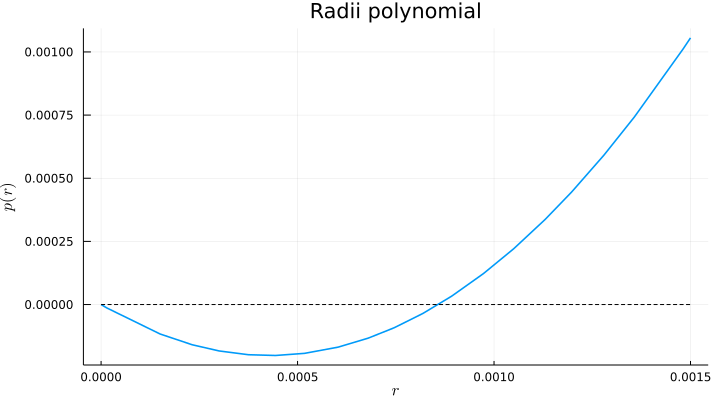

In [11]:
# radii-polynomial
using ForwardDiff
rp(r) = Z₂(r).*r - (1-Z₁-Z₀)*r + Y₀

function newton(F,x0) # Newton iteration
    tol = 5e-10; count = 0
    x = x0
    Fx = F(x)
    while maximum(abs,Fx)/abs(x) ≥ tol && count ≤ 20
        DF = ForwardDiff.derivative(F,x)
        x -= DF\Fx
        Fx = F(x)
        count += 1
    end
    return x
end

r₀ = newton(rp,1e-10)
if r₀ < 0
  println("Newton-Kantorovich theorem is failed to verify.")
end
println("r₀ = $r₀")
plot(rp,0,0.0015,
    xlabel = "\$r\$",
    ylabel = "\$p\\,(r)\$",
    line   = 1.6,
    title  = "Radii polynomial",
    size   = (720,400),
    legend = false,
)
plot!(z->0,0,0.0015,linestyle=:dash,linecolor=:black)